### MMA 860 Team Project: Predicting Housing Prices

Team Istanbul

In [1]:
# %pip install openpyxl
# %matplotlib inline
# %pip install statsmodels
# %pip install scikit-learn seaborn
# %pip install jupyter_contrib_nbextensions

In [2]:
import pandas as pd
import numpy as np

import statsmodels.imputation.mice as mice
import statsmodels.api as sm
from statsmodels.formula.api import ols
 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
 
from sklearn import linear_model
#import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Converting data source to dataframes
file_path_test  = "test.csv"
file_path_train = "train.csv"

df_test  = pd.read_csv(file_path_test, index_col="Id")
df_train = pd.read_csv(file_path_train, index_col="Id")

In [4]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### UDFs

### Project Code

#### Data Cleaning
1. Check for nulls
2. Check of data-type inconsistencies
3. Check for duplicate rows
4. Check for outliers
5. Test for biases after imputations


In [5]:
#checking for datatype
print(df_train.dtypes)

#Print column with inconsistent datatypes (if any)
for col in df_train.columns:
    unique_types = set(df_train[col].dropna().apply(type)) 
    if len(unique_types) > 1:
        print(f"Column '{col}' has inconsistent data types: {unique_types}")

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object


In [6]:
df_train.shape

(1460, 80)

In [7]:
#check for duplicates
duplicate_count = df_train.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [8]:
cols = df_train.columns.tolist()

#Checking column names; removing spaces from name
for col in cols:
    if ' ' in col:
        new_col = col.replace(' ', '')
        print(f"Removing space in {col}: new name {new_col}")
        
        df_train.rename(columns={col: new_col}, inplace=True)

In [9]:
#Checking if any columns are completely empty
for col in cols:
    if df_train[col].astype(str).str.strip().eq('').all():
        print(f"Column {col} is empty. To be deleted...")

In [10]:
#Checking for nulls in columns (grouped by datatype)

#Initializing lists to store column names with null values
col_num_nulls = []
col_obj_nulls = []

for dtype in sorted(df_train.dtypes.unique(), key=str):  
    
    # Select columns of the current data type and sort by null count
    cols = [col for col in df_train.columns if df_train[col].dtypes == dtype]
    sorted_cols = sorted(cols, key=lambda col: df_train[col].isnull().sum(), reverse=True)
    
    if df_train[col].isnull().sum() == 0:
        print(f"------------- {dtype} -------------")
    
    # Print columns and their respective null counts
    for col in sorted_cols:
        null_count = df_train[col].isnull().sum()
        if null_count > 0:
            print(f"{col} : {null_count}")
            
            #Storing column names in the lists
            if dtype == 'object':
                col_obj_nulls.append(col)
            else:
                col_num_nulls.append(col)

    print("\n")

------------- float64 -------------
LotFrontage : 259
GarageYrBlt : 81
MasVnrArea : 8




------------- object -------------
PoolQC : 1453
MiscFeature : 1406
Alley : 1369
Fence : 1179
FireplaceQu : 690
GarageType : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
BsmtExposure : 38
BsmtFinType2 : 38
BsmtQual : 37
BsmtCond : 37
BsmtFinType1 : 37
MasVnrType : 8
Electrical : 1




<h6 style="color: #ff5733;">Null Count Findings:</h6>

1. No spaces found in column names. 
2. There are no columns that are completely empty. 
3. There are no duplicate rows.

**Float Data Type**
1. There are 3 float type columns with null values. 
2. The maximum number of null values in a column are 259. 
3. All null values can be populated using multiple imputations

**Object Data Type**
1. There are 22 object type columns with null values. 
2. There are 4 columns that are more than 45% empty (i.e. less than 55% populated), therefore these columns must be deleted to prevent model skewing: <br>
&nbsp;&nbsp;&nbsp;&nbsp;<table>
    <tr>
        <th>Column</th>
        <th>Null Values</th>
        <th>Percent Empty</th>
    </tr>
    <tr>
        <td>PoolQC</td>
        <td>1453</td>
        <td>99.5%</td>
    </tr>
    <tr>
        <td>MiscFeature</td>
        <td>1406</td>
        <td>96.3%</td>
    </tr>
    <tr>
        <td>Alley</td>
        <td>1369</td>
        <td>93.8%</td>
    </tr>
    <tr>
        <td>Fence</td>
        <td>1179</td>
        <td>80.7%</td>
    </tr>
    <tr>
        <td>FireplaceQu</td>
        <td>690</td>
        <td>47.3%</td>
    </tr>
</table>
<br>3. For the remainder columns, 'None' will replace any empty values in the column. Using 'None' implies that the feature doesn't apply to that record. Adding another value could incorrectly skew the weight & outcome of that column. After adding 'None', <span style="background-color: yellow;"> we need to ensure the value/area of the corresponding feature is 0 (as imputation could add a non-zero value to it.</span> 

In [11]:
#Running multiple imputations on numeric columns feat
df_numeric = df_train.loc[:, col_num_nulls]
imp        = mice.MICEData(df_numeric)
imp.next_sample()

imputed_data = imp.data

# Update df_train with the imputed values
for col in df_numeric.columns:
    df_train[col] = df_train[col].where(df_train[col].notnull(), imputed_data[col])

In [12]:
#Replacing null values in object columns with 'None'
for col in col_obj_nulls:
    df_train[col] = df_train[col].fillna('None')

#Dropping columns that more than 45% empty 
df_train = df_train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis = 1)

In [13]:
#Checking no null values remain
cols = df_train.columns.tolist()

for col in cols:
    null_count = df_train[col].isnull().sum()
    if null_count > 0:
        print(f"{col} : {null_count}")

In [14]:
#Ensuring the value/area of the corresponding feature is 0

#If BsmtQual == None then TotalBsmtSF and TotalBsmtSF should be 0
df_train.loc[df_train['BsmtQual'].isnull(), ['TotalBsmtSF', 'BsmtUnfSF']] = 0

#If BsmtFinType2 == None then BsmtFinSF2 should be 0
df_train.loc[df_train['BsmtFinType2'].isnull(), ['BsmtFinSF2']] = 0

#If BsmtFinType1 == None then BsmtFinSF1 should be 0
df_train.loc[df_train['BsmtFinType1'].isnull(), ['BsmtFinSF1']] = 0

In [15]:
#Checking the above logic is being followed (value/area when feature doesn't exist should be 0)

logic_violated = False

#Check for basement quality vs total basement area & unfinished basement area
if not df_train.loc[df_train['BsmtQual'].isnull() & 
                    ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))].empty:
    print("Rows violating BsmtQual logic:")
    print(df_train.loc[df_train['BsmtQual'].isnull() & 
                       ((df_train['TotalBsmtSF'] != 0) | (df_train['BsmtUnfSF'] != 0))])

#Check for first basement quality and first basement area
if not df_train.loc[df_train['BsmtFinType1'].isnull() & 
                (df_train['BsmtFinSF1'] != 0)].empty:
    print("\nRows violating BsmtFinType1 logic:")
    print(df_train.loc[df_train['BsmtFinType1'].isnull() & 
                       (df_train['BsmtFinSF1'] != 0)])

#Check for second basement quality and second basement are
if not df_train.loc[df_train['BsmtFinType2'].isnull() & 
                    (df_train['BsmtFinSF2'] != 0)].empty:
    print("\nRows violating BsmtFinType2 logic:")
    print(df_train.loc[df_train['BsmtFinType2'].isnull() & 
                       (df_train['BsmtFinSF2'] != 0)])

if not logic_violated:
    print("No logic violdated.")


No logic violdated.


<h5 style="color: blue;">Numeric Columns</h5>

1. Test numeric columns
2. Clean and add data wherever necessary

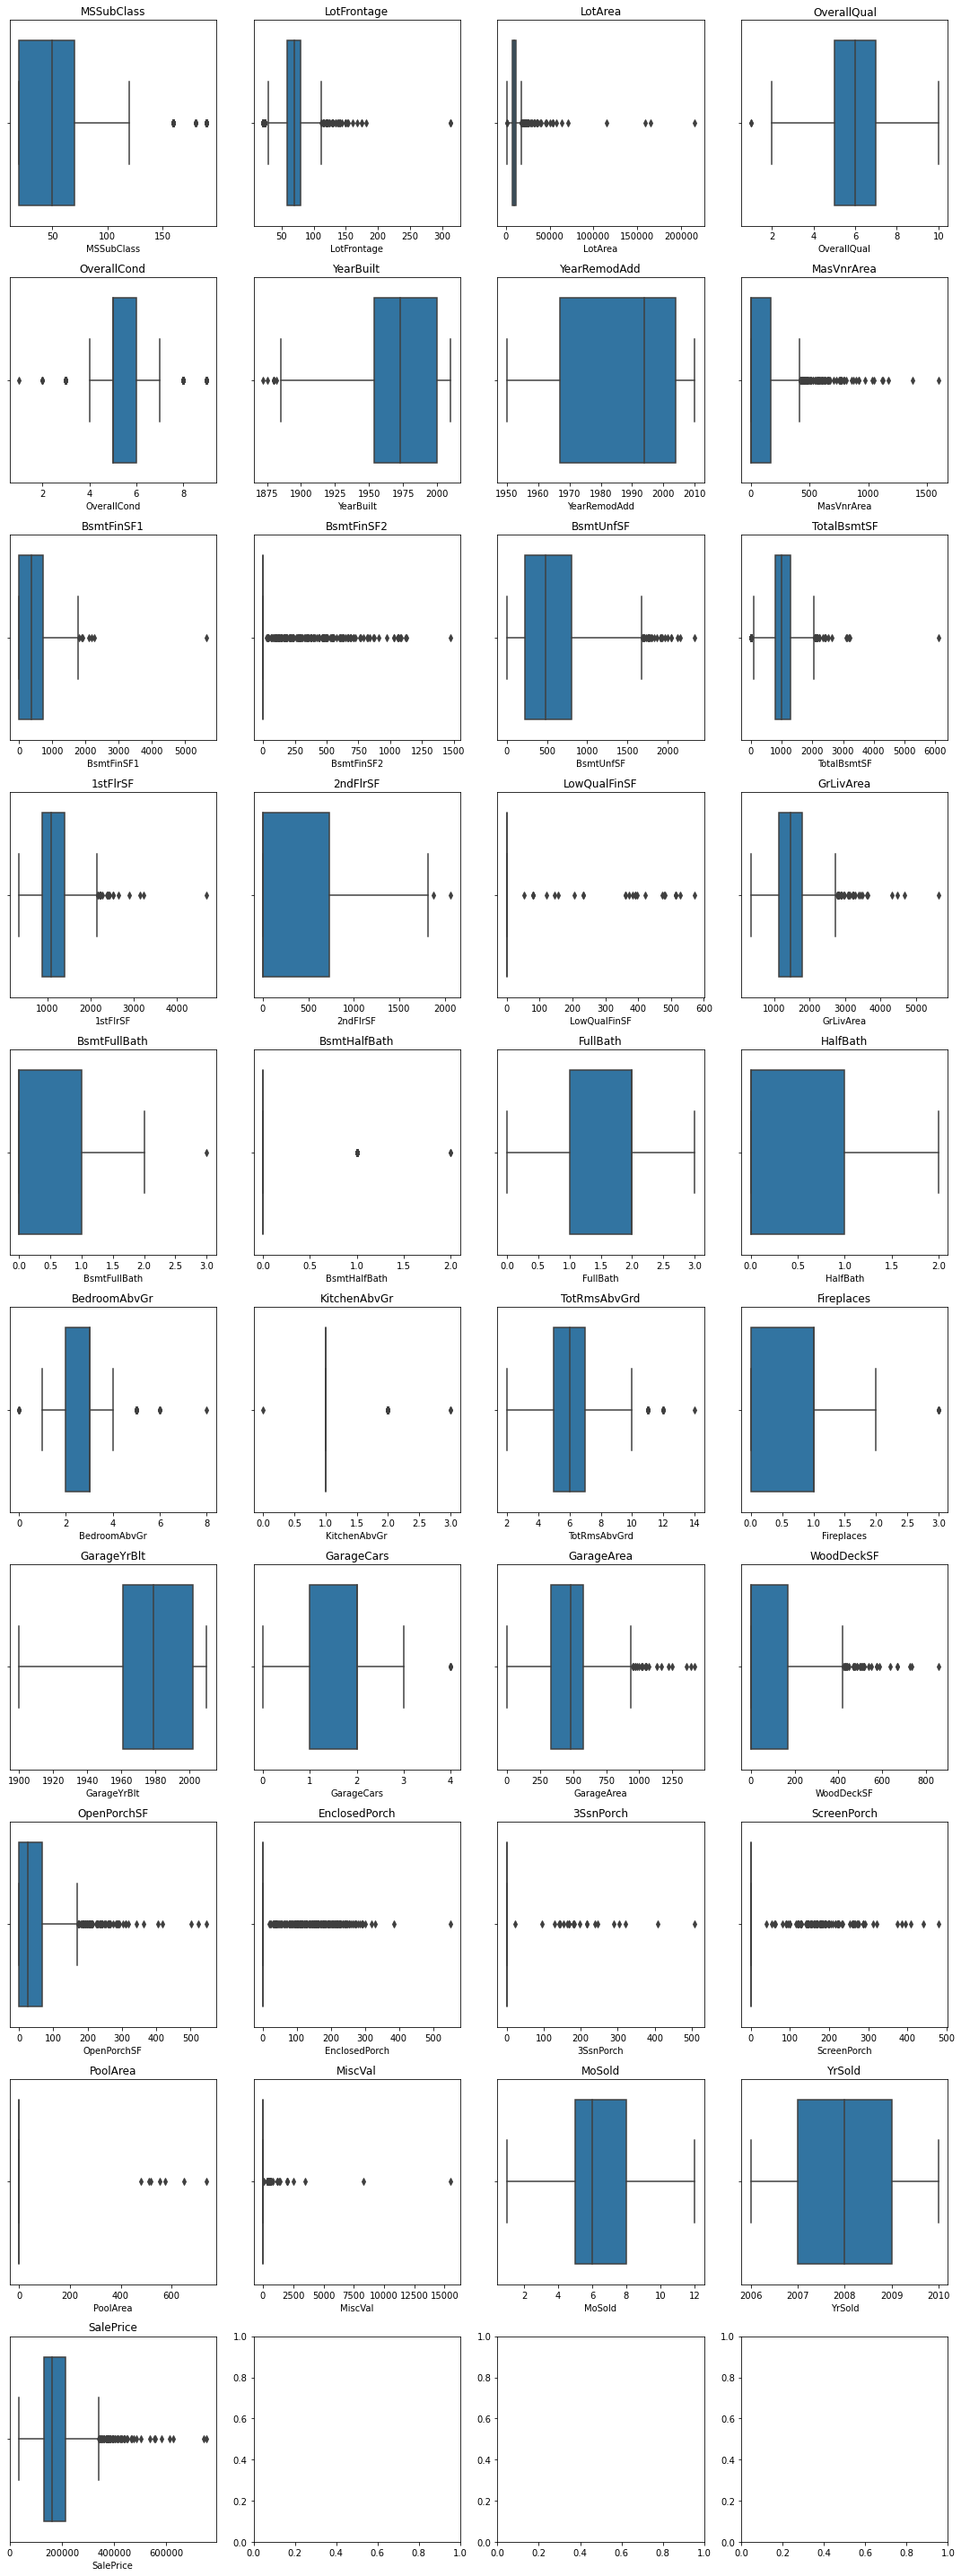

In [16]:
num_cols = df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Define the number of plots per row
plots_per_row = 4
num_cols_count = len(num_cols)
rows = (num_cols_count // plots_per_row) + (num_cols_count % plots_per_row > 0) 

# Create subplots
fig, axes = plt.subplots(rows, plots_per_row, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Box plot for each numeric column
for i, col in enumerate(num_cols):
    sns.boxplot(x=df_train[col], ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

<h6 style="color: #ff5733;">Outlier Findings:</h6>

A lot numeric columns contain outliers (as can be seen in the box and whisker plots), however it isn't necessary to remove the outliers because:
1. **Area columns:** For features related to area, the value of 0 is the most frequent value, representing unfinished or non-existent features. In these cases, other values are technically outliers, but 0 simply indicates the absence of that feature. Removing them would misrepresent the data.
2. **Condition columns:** These columns contain ratings for various aspects of the house, such as its condition. While extreme low or high ratings may appear as outliers, they actually reflect the true condition of the house. Removing these values would distort the representation of house conditions.

<h5 style="color: blue;">Categorical Columns</h5>

1. Test categorical columns
2. Clean and add data wherever necessary

In [17]:
#Checking for distinct values in all colums of datatype 'object'
cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# 
for col in cat_cols:
    print(f"In column {col}: ")
    print(df_train[col].unique())
    print("\n")

In column MSZoning: 
['RL' 'RM' 'C (all)' 'FV' 'RH']


In column Street: 
['Pave' 'Grvl']


In column LotShape: 
['Reg' 'IR1' 'IR2' 'IR3']


In column LandContour: 
['Lvl' 'Bnk' 'Low' 'HLS']


In column Utilities: 
['AllPub' 'NoSeWa']


In column LotConfig: 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


In column LandSlope: 
['Gtl' 'Mod' 'Sev']


In column Neighborhood: 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']


In column Condition1: 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


In column Condition2: 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']


In column BldgType: 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


In column HouseStyle: 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


In column RoofStyle: 
['Gable' 'Hip' 

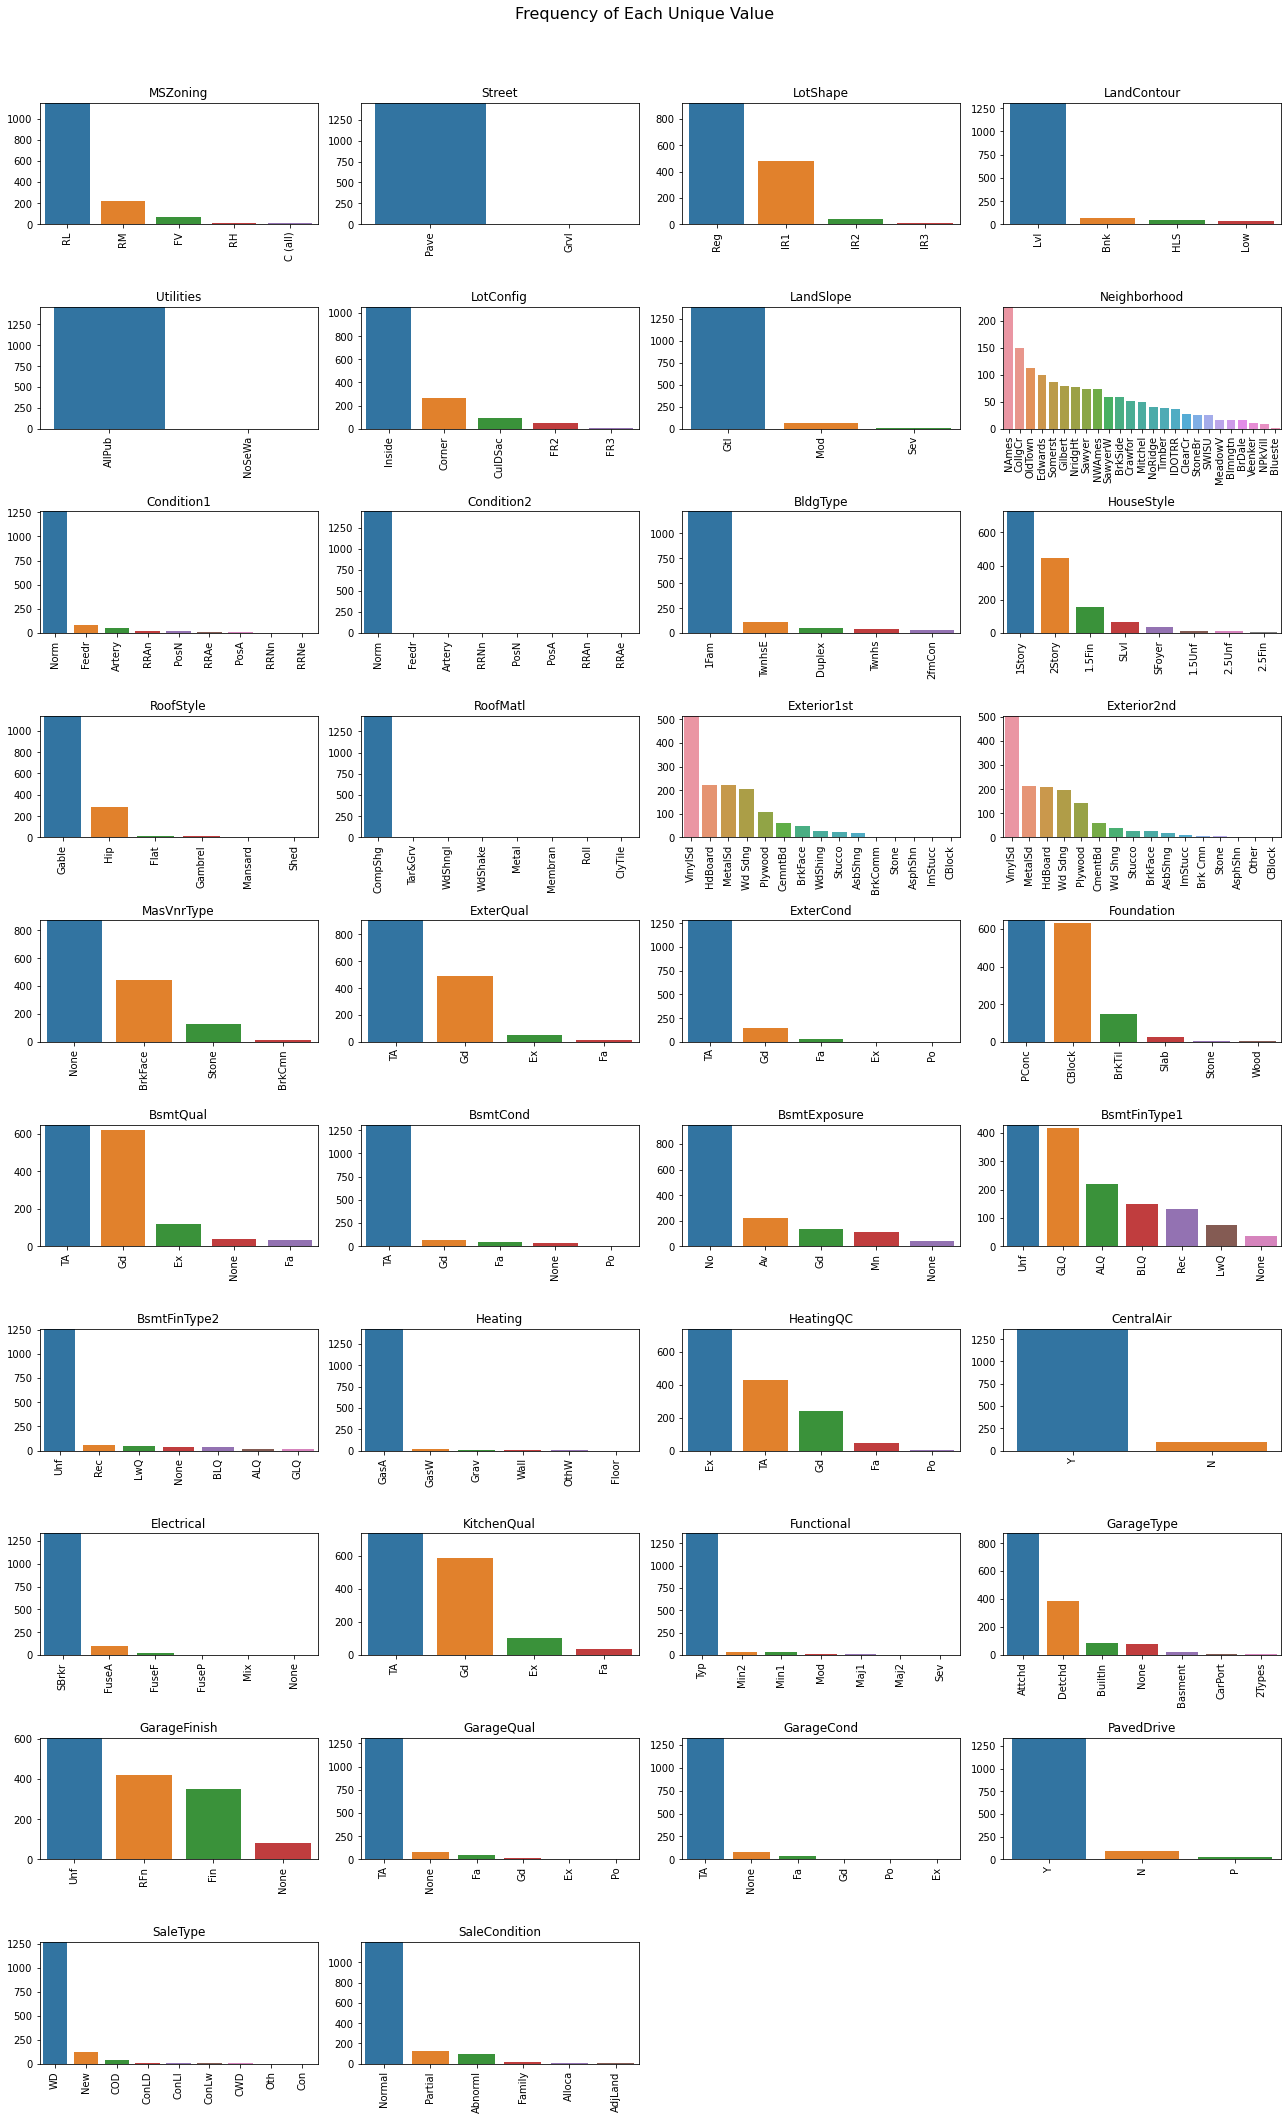

In [18]:
#Plotting the frequency of each unique value
cols = df_train.select_dtypes(include=['object']).columns 
num_cols = len(cols)
num_rows = (num_cols // 4) + (num_cols % 4 > 0)

plt.figure(figsize=(18, num_rows * 3))  
plt.suptitle('Frequency of Each Unique Value', fontsize=16)

index = 1

for index, col in enumerate(cols, start=1):
    plt.subplot(num_rows, 4, index)
    plt.xticks(rotation=90)
    plt.title(col)

    count = df_train[col].value_counts()
    
    sns.barplot(x = count.index, y = count.values)
    
    plt.ylim(0, count.max())
    index +=1
    

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [19]:
#From the graphs, testihng counts for columns that appear skewed in value distribution
test_cols = ['Utilities', 'Street', 'Condition2', 'RoofMatl']

for col in test_cols:
    print(f"Column {col} values:")
    print(df_train[col].value_counts())
    print("\n")

Column Utilities values:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64


Column Street values:
Pave    1454
Grvl       6
Name: Street, dtype: int64


Column Condition2 values:
Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


Column RoofMatl values:
CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64




<h6 style="color: #ff5733;">Unique Value & Frequency Findings:</h6>

Based on the graphs and the 4 columns tested above, one value in each column is over represented. Therefore, in the overall regression model, these columns wouldn't make much of a difference. However, a balance must be maintained between simplifying the model while retaining sensitivity to variance

| Column | Action | Logic |
| :--- | :--- | :--- |
| Utilities | <span style="color: red;">Remove</span> | Column has no variability and will only introduce noise. |
| Street| <span style="color: red;">Remove</span>  | Column has no variability and will only introduce noise. |
| Condition2 | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |
| RoofMtl | <span style="color: green;">Keep</span> | Even though one value is overrepresented, it's important to keep the variance for model sensitivity |

This approach balances model efficacy and simplicity

#### Exploratory Data Analysis
1. Statistical analysis of variables


#### Feature Engineering
1. Dummy variables/One Hot Encoding
2. Test variable significance
3. Collinearity analysis
4. Dimension reduction

#### Predictive Modelling
1. Multiple Lineaer Regression
2. Heteroskedascity analysis
3. Hypothesis Testing
4. MAE and RMSE analysis

In [20]:
# # Split our preprocessed data into our features and target arrays
# y = application_df['IS_SUCCESSFUL'].values
# X = application_df.drop(['IS_SUCCESSFUL'],1).values
# # Split the preprocessed data into a training and testing dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [21]:
# # Create a StandardScaler instances
# scaler = StandardScaler()

# # Fit the StandardScaler
# X_scaler = scaler.fit(X_train)

# # Scale the data
# X_train_scaled = X_scaler.transform(X_train)
# X_test_scaled = X_scaler.transform(X_test)

In [22]:
# # Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# number_input_features = len(X_train[0])
# hidden_nodes_layer1 = 80
# hidden_nodes_layer2 = 30

# nn = tf.keras.models.Sequential()

# # First hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer1, 
#                              input_dim = number_input_features, 
#                              activation = "relu"))

# # Second hidden layer
# nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, 
#                              activation = "relu"))

# # Output layer
# nn.add(tf.keras.layers.Dense(units = 1, 
#                              activation = "sigmoid"))

# # Check the structure of the model
# nn.summary()

## Predictive Modeling with Hypothesis and Heteroskedasticity Testing

In [23]:

# Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:

# Load and prepare training data
train_df = pd.read_csv("train.csv")
train_df_clean = train_df.dropna(subset=["SalePrice"])
train_df_clean = train_df_clean.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "LotFrontage"], errors='ignore')
train_df_clean = train_df_clean.fillna(train_df_clean.median(numeric_only=True))

# Target and features
y = np.log1p(train_df_clean["SalePrice"])
X = train_df_clean.drop(columns=["SalePrice", "Id"])
X = pd.get_dummies(X, drop_first=True)

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"Validation RMSE (log-transformed): {rmse:.4f}")


Validation RMSE (log-transformed): 0.2084


In [26]:

# Hypothesis testing using OLS
X_train_sm = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())


/Users/rabab/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     70.00
Date:                Sun, 06 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:14:47   Log-Likelihood:                 1123.0
No. Observations:                1168   AIC:                            -1792.
Df Residuals:                     941   BIC:                            -642.6
Df Model:                         226                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.59

In [27]:

# Breusch-Pagan heteroskedasticity test
bp_test = het_breuschpagan(ols_model.resid, ols_model.model.exog)
print("Breusch-Pagan test p-value:", bp_test[1])
print("Interpretation: If p < 0.05, heteroskedasticity is likely present.")


Breusch-Pagan test p-value: 1.3655482313760242e-32
Interpretation: If p < 0.05, heteroskedasticity is likely present.


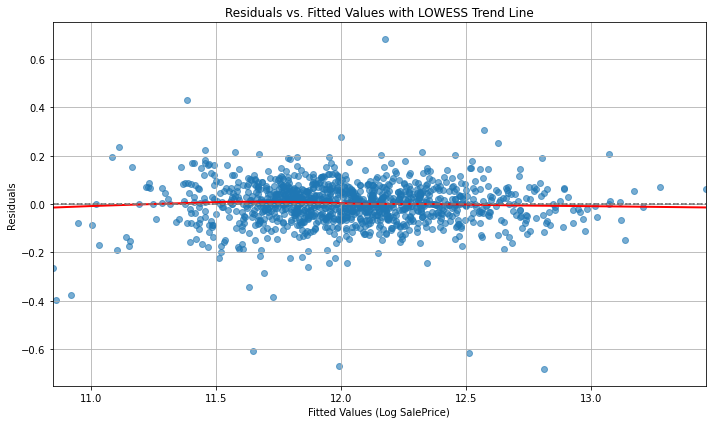

In [28]:

# Residuals vs. Fitted Values with LOWESS trend line
fitted_vals = ols_model.fittedvalues
residuals = ols_model.resid

plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, 
              line_kws={'color': 'red', 'lw': 2}, 
              scatter_kws={'alpha': 0.6})
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted Values (Log SalePrice)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted Values with LOWESS Trend Line")
plt.grid(True)
plt.tight_layout()
plt.show()
